In [36]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)



import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [37]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# Download census-income dataset

In [38]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [39]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [40]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [41]:
train

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,train
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,valid
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,train
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,train


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [42]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [43]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [44]:
print(target)

 <=50K


In [45]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [46]:
cat_idxs

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [47]:
cat_dims

[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]

In [48]:
categorical_columns

['39',
 ' State-gov',
 ' Bachelors',
 ' 13',
 ' Never-married',
 ' Adm-clerical',
 ' Not-in-family',
 ' White',
 ' Male',
 ' 2174',
 ' 0',
 ' 40',
 ' United-States',
 ' <=50K',
 'Set']

In [49]:
categorical_dims

{'39': 73,
 ' State-gov': 9,
 ' Bachelors': 16,
 ' 13': 16,
 ' Never-married': 7,
 ' Adm-clerical': 15,
 ' Not-in-family': 6,
 ' White': 5,
 ' Male': 2,
 ' 2174': 119,
 ' 0': 92,
 ' 40': 94,
 ' United-States': 42,
 ' <=50K': 2,
 'Set': 3}

# Network parameters

In [50]:
tabnet_params = {"cat_idxs":[],
                 "cat_dims":[],
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
)

Device used : cuda


In [51]:
!nvidia-smi

Tue Feb 15 11:47:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   49C    P3    48W / 270W |   6058MiB /  8192MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Training

In [52]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [53]:
train[features]

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
0,33,6,83311,9,12,2,4,0,4,1,0,0,12,39
1,21,4,215646,11,8,0,6,1,4,1,0,0,39,39
2,36,4,234721,1,6,2,6,0,2,1,0,0,39,39
3,11,4,338409,9,12,2,10,5,2,0,0,0,39,5
4,20,4,284582,12,13,2,4,5,4,0,0,0,39,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,10,4,257302,7,11,2,13,5,4,0,0,0,37,39
32556,23,4,154374,11,8,2,7,0,4,1,0,0,39,39
32557,41,4,151910,11,8,6,1,4,4,0,0,0,39,39
32558,5,4,201490,11,8,4,1,3,4,1,0,0,19,39


In [54]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [55]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    save_history.append(clf.history["valid_auc"])
    
#assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.53703 | train_auc: 0.50676 | valid_auc: 0.50958 |  0:00:01s
epoch 1  | loss: 0.43094 | train_auc: 0.70242 | valid_auc: 0.69362 |  0:00:02s
epoch 2  | loss: 0.40915 | train_auc: 0.75966 | valid_auc: 0.74888 |  0:00:03s
epoch 3  | loss: 0.39796 | train_auc: 0.7935  | valid_auc: 0.77988 |  0:00:04s
epoch 4  | loss: 0.39154 | train_auc: 0.85257 | valid_auc: 0.85305 |  0:00:05s
epoch 5  | loss: 0.38714 | train_auc: 0.87421 | valid_auc: 0.87568 |  0:00:06s
epoch 6  | loss: 0.38429 | train_auc: 0.88999 | valid_auc: 0.89276 |  0:00:07s
epoch 7  | loss: 0.38529 | train_auc: 0.90447 | valid_auc: 0.90704 |  0:00:08s
epoch 8  | loss: 0.38437 | train_auc: 0.90357 | valid_auc: 0.90451 |  0:00:10s
epoch 9  | loss: 0.37512 | train_auc: 0.90797 | valid_auc: 0.90898 |  0:00:11s
epoch 10 | loss: 0.37931 | train_auc: 0.90918 | valid_auc: 0.90992 |  0:00:12s
epoch 11 | loss: 0.37629 | train_auc: 0.91161 | valid_auc: 0.91295 |  0:00:13s
epoch 12 | loss: 0.37298 | train_auc: 0.9129  | vali

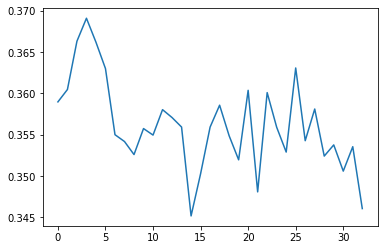

In [56]:
# plot losses
plt.plot(clf.history['loss'])

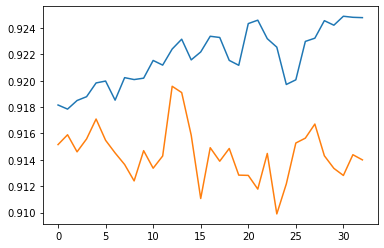

In [57]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

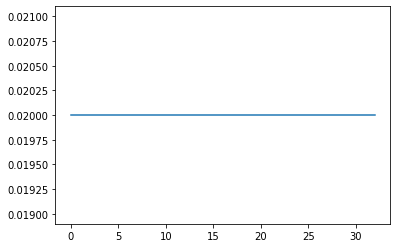

In [58]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [59]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9195779981120294
FINAL TEST SCORE FOR census-income : 0.9078044592529755


In [60]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [61]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'not_wealthy', 'wealthy'], dtype='<U11')

# Save and load Model

In [62]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [63]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [64]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9078044592529755


In [65]:
assert(test_auc == loaded_test_auc)

In [66]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'not_wealthy', 'wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [67]:
clf.feature_importances_

array([0.1380258 , 0.04361629, 0.01575761, 0.03607979, 0.13761124,
       0.11759961, 0.02000795, 0.0598994 , 0.01971649, 0.03099307,
       0.18001425, 0.08598629, 0.10802175, 0.00667047])

# Local explainability and masks

In [68]:
explain_matrix, masks = clf.explain(X_test)

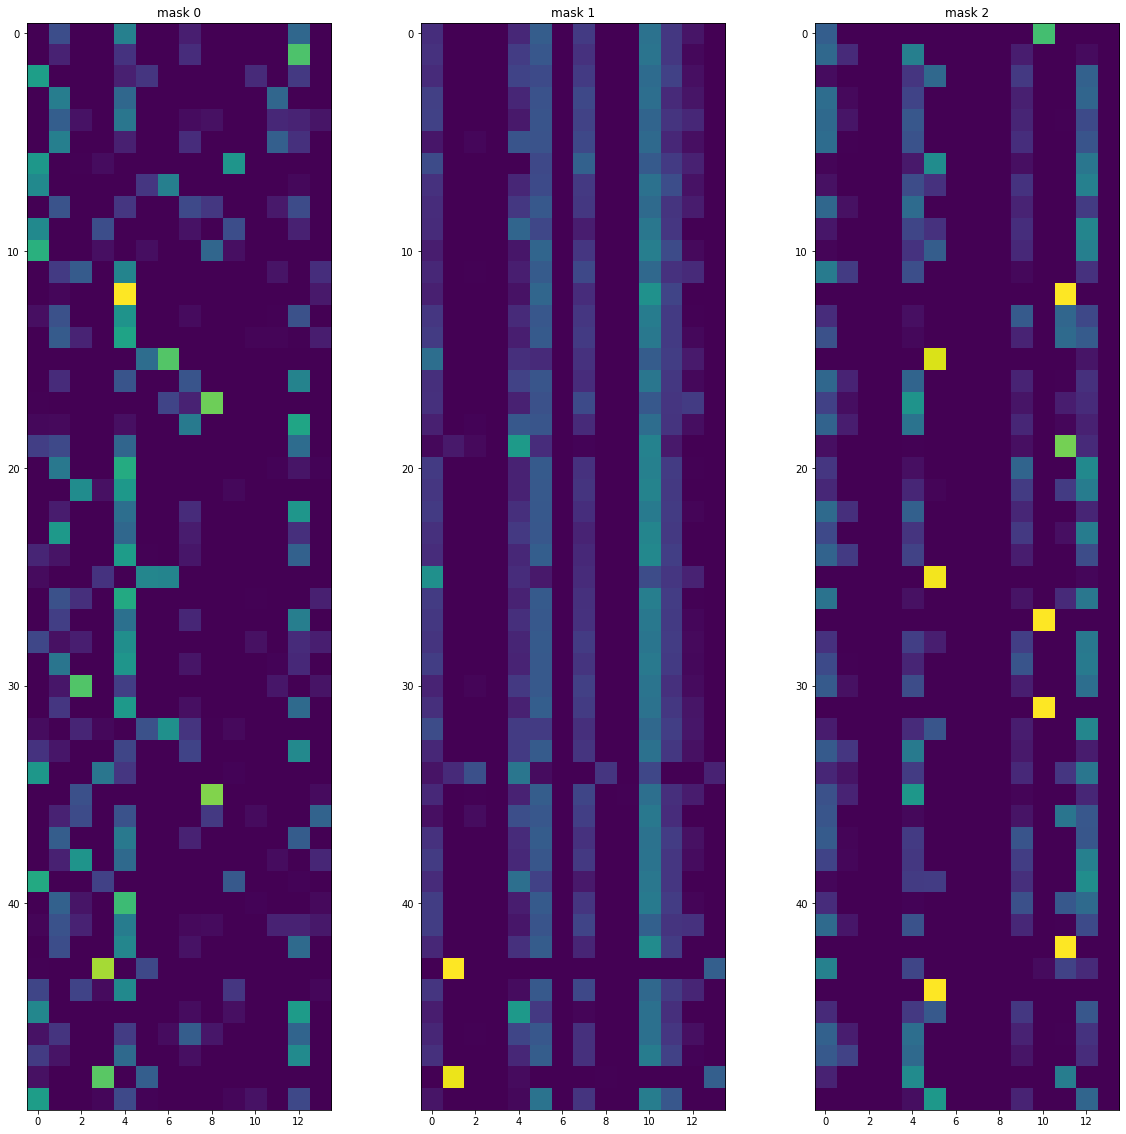

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [70]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)